## Sentiment Analysis

### Text

- textblob.sentiments: NaiveBayesAnalyzer, PatternAnalyzer
    - result: polarity [-1,1], subjectivity [-1,1]

- VADER: 

In [4]:
# %pip install vaderSentiment
# %pip install textblob

  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
from preprocessing.preprocessing import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from scipy.special import softmax
import re, string
import emoji

In [ ]:
# load data
# df = load_dataset(subset_name="climatevisions_2019_popular")
df = pd.read_excel("/Users/inken/Desktop/result_mostlikeddataset_current.xlsx")
df = preprocess_dataset(df, selected_columns=None)

img_path_jan = "/Users/inken/Desktop/Mannheim/FSS 2024/Team Project/Dataset/01_January/" #TODO: adjust paths
img_path_feb = "/Users/inken/Desktop/Mannheim/FSS 2024/Team Project/Dataset/02_February/"
img_path_mar = "/Users/inken/Desktop/Mannheim/FSS 2024/Team Project/Dataset/03_March/"
df

In [12]:
dataset_path = '/Users/inken/Desktop/climatevisions_2019_random.h5'
raw_dataset = h5py.File(dataset_path,'r+') 

    # Access the 'upper' data - we only have tweet data 
for item in raw_dataset.keys():
    print("Items: " + item)    
        
    # Access the actual subgroups with data for us - different info we can look at - mostly things provided in Excel by Katharina
for item in raw_dataset.require_group('tweet_data').keys():
    continue  ### comment this out if you want to see categories we have and use print

    # Access the dataset within the group
dataset = raw_dataset['tweet_data']  ## excludes unnecessary information - only tweet_data
    
    # Create a dictionary to store column data
data_dict = {}
        
    # Iterate through the keys (assuming each key is a column name)
for key in dataset.keys():
        # Access the data for each column
    column_data = dataset[key][:]
            
        # Store the data in the dictionary with the column name as the key
    data_dict[key] = column_data
    
    # Convert the dictionary to a Pandas DataFrame
df_10000 = pd.DataFrame(data_dict)


Items: tweet_data


In [7]:
df_10000 = preprocess_dataset(df_10000, selected_columns=None)

(10000, 9)


In [6]:
# textblob
# from textblob import TextBlob
# from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer

# text = "That is really dangerous"
# print(TextBlob(text, analyzer=NaiveBayesAnalyzer()).sentiment)
# print(TextBlob(text, analyzer=PatternAnalyzer()).sentiment)

In [13]:
# VADER
df_sentiments_vader = df_10000.copy()

sentiment = SentimentIntensityAnalyzer()

df_sentiments_vader['pos'] = [sentiment.polarity_scores(x)['pos'] for x in df_sentiments_vader['text']]
df_sentiments_vader['neu'] = [sentiment.polarity_scores(x)['neu'] for x in df_sentiments_vader['text']]
df_sentiments_vader['neg'] = [sentiment.polarity_scores(x)['neg'] for x in df_sentiments_vader['text']]


df_sentiments_vader.head()


TypeError: can only concatenate str (not "int") to str

In [9]:
df_sentiments_high_pos = df_sentiments_vader[df_sentiments_vader['pos'] > 0.5]
df_sentiments_high_neu = df_sentiments_vader[df_sentiments_vader['neu'] > 0.5]
df_sentiments_high_neg = df_sentiments_vader[df_sentiments_vader['neg'] > 0.5]

with pd.option_context('display.max_colwidth', -1):
    print("pos:", df_sentiments_high_pos['text'])

with pd.option_context('display.max_colwidth', -1):
    print("neg:", df_sentiments_high_neg['text'])


pos: 784    It was a great honor & pleasure to welcome @SadhguruJV @ishafoundation at @UNFCCC. We discussed creative, natural, behavioral, ethical & innovative approaches to change #ClimateChange discourse. Looking forward to benefit from Sadhguru Ji\xe2\x80\x99s wisdom & insights. https://t.co/cjNZrjMY2V
Name: text, dtype: string
neg: 81      We\xe2\x80\x99re all going to die from irony poisoning if climate change doesn\xe2\x80\x99t kill us first. https://t.co/iB2NfFwYCp
4487    Parents scared of Momo ignoring kids scared of climate\xc2\xa0change https://t.co/0l01dgvAK4 https://t.co/MZzSwlZpSf              
Name: text, dtype: string


## roBERTa

In [10]:
# %pip install transformers
# %pip install scipy# %pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [14]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

In [15]:
# Initialize the columns for the sentiment scores
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

df_sent = df_10000.copy()
df_sent['Negative'] = 0.0
df_sent['Neutral'] = 0.0
df_sent['Positive'] = 0.0
df_sent['text_sent'] = ""

excluded = 0
# Go through the whole dataframe and check for tweet length
# if tweet too long exclude it
for index, row in df_sent.iterrows():
    tweet_text = row['text']
    no_emoji_tweet = emoji.replace_emoji(tweet_text, "")
    encoded_tweet = tokenizer(str(no_emoji_tweet), return_tensors='pt')
    
    shape = encoded_tweet['input_ids'].shape
    if shape[1] > 512:
        # print("Tweet too long")
        excluded += 1
        continue

    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    max_score_idx = list(scores).index(max(scores))

    # Assign the scores to the respective columns
    df_sent.at[index, 'Negative'] = scores[0]
    df_sent.at[index, 'Neutral'] = scores[1]
    df_sent.at[index, 'Positive'] = scores[2]
    df_sent.at[index, 'text_sent'] = labels[max_score_idx]

print(f"{excluded} tweets have been skipped due to their length.")
df_sent

TypeError: cannot use a string pattern on a bytes-like object

In [11]:
# save as csv
df_sent.to_csv('results_text/results_text_roBERTa_10000.csv', header=True, index=False)


In [29]:
df_sent_high_pos = df_sent[df_sent['positive'] > 0.7]
df_sent_high_neu = df_sent[df_sent['neutral'] > 0.7]
df_sent_high_neg = df_sent[df_sent['negative'] > 0.7]

#print shapes
print(df_sent_high_pos.shape)
print(df_sent_high_neu.shape)
print(df_sent_high_neg.shape)

In [31]:
with pd.option_context('display.max_colwidth', -1):
    print("pos:", df_sent_high_pos['text'])

with pd.option_context('display.max_colwidth', -1):
    print("neg:", df_sent_high_neg['text'])

pos: 9       b"From nurseries to full forest areas, the success of Billion Tree Tsunami has been unprecedented with public & pvt involvement. Has given us confidence to take the initiative to 10 bn trees. KP's forest cover has increased by 4%, contributing to the fight against climate change https://t.co/xFqJpwUq0u"      
14      .@FIAFormulaE tonight is announcing that it has enlisted super viral K-pop group @BTS_twt to help promote electric vehicles and combating climate change.\xe2\x9e\x96 BTS is one of the most followed music acts in the world, with more than 90 million social media followers. https://t.co/7FSvU3RsLw              
15      Friendly nations, futuristic outcomes. The RIC (Russia-India-China) meeting was an excellent forum to discuss ways to enhance multilateral cooperation between our nations and work to mitigate challenges being faced by our planet, most notably terrorism and climate change. https://t.co/LTljcPCTDW              
16      Formula E is joining forces wi

In [ ]:
# save as csv
# df_sent.to_csv('text_sentiment_data.csv', header=True, index=False)


51781


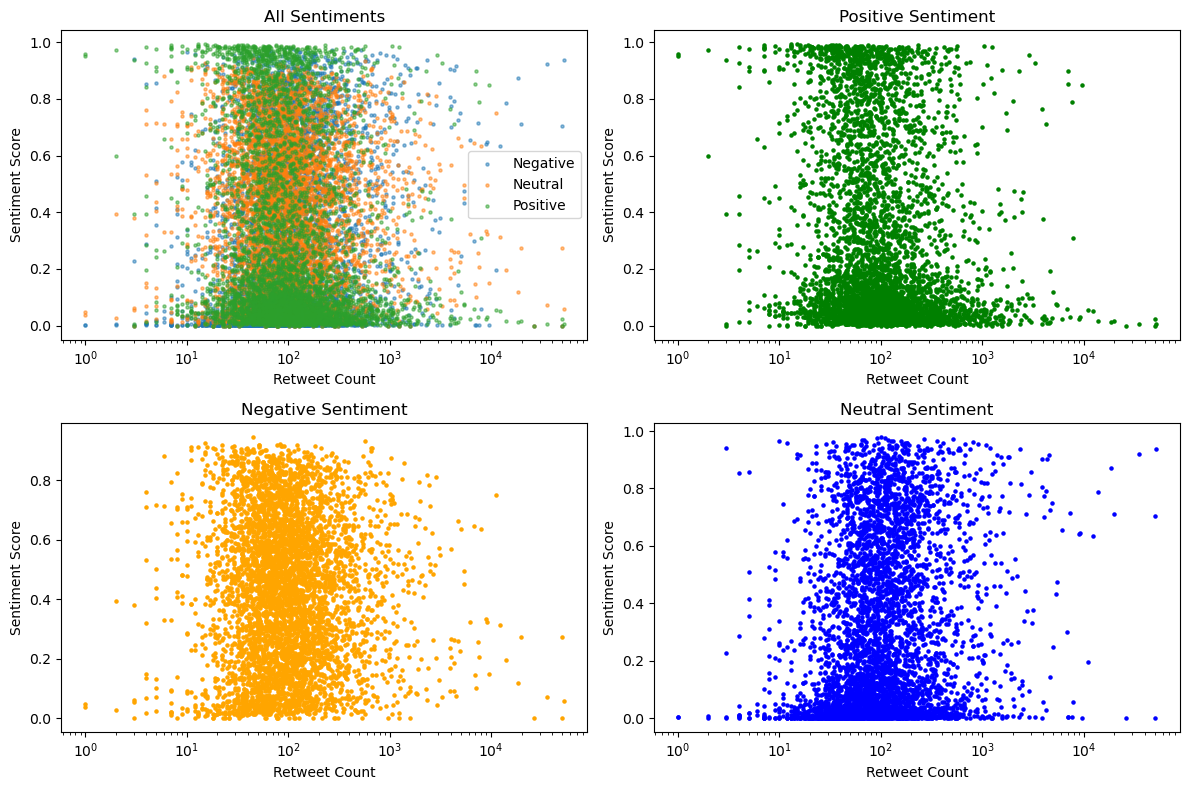

In [27]:
# relationship between retweet count and sentiment
print(df_sent['retweet_count'].astype(int).max())

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(df_sent['retweet_count'].astype(int), df_sent['negative'], label='Negative', s=5, alpha=0.5)
plt.scatter(df_sent['retweet_count'].astype(int), df_sent['neutral'], label='Neutral', s=5, alpha=0.5)
plt.scatter(df_sent['retweet_count'].astype(int), df_sent['positive'], label='Positive', s=5, alpha=0.5)
plt.xscale('log')
plt.xlabel('Retweet Count')
plt.ylabel('Sentiment Score')
plt.legend()
plt.title('All Sentiments')

plt.subplot(2, 2, 2)
plt.scatter(df_sent['retweet_count'].astype(int), df_sent['positive'], label='Positive', s=5, c='green')
plt.xscale('log')
plt.xlabel('Retweet Count')
plt.ylabel('Sentiment Score')
plt.title('Positive Sentiment')

plt.subplot(2, 2, 3)
plt.scatter(df_sent['retweet_count'].astype(int), df_sent['neutral'], label='Neutral', s=5, c='orange')
plt.xscale('log')
plt.xlabel('Retweet Count')
plt.ylabel('Sentiment Score')
plt.title('Negative Sentiment')

plt.subplot(2, 2, 4)
plt.scatter(df_sent['retweet_count'].astype(int), df_sent['negative'], label='Negative', s=5, c='blue')
plt.xscale('log')
plt.xlabel('Retweet Count')
plt.ylabel('Sentiment Score')
plt.title('Neutral Sentiment')

plt.tight_layout()
plt.show()